## **라이브러리 다운로드 및 불러오기**

In [ ]:
## 라이브러리 불러오기

# 데이터 크롤링
#!pip3 install selenium==3.141
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import requests

# 데이터 핸들링
import numpy as np
import pandas as pd
import datetime
import re
from time import sleep
import time
import random
import csv

print("pandas version: ", pd.__version__)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

pandas version:  2.2.2


In [ ]:
# 딜레이 시간 설정
pause_time = random.uniform(0.6, 0.8)

___

## **크롬 드라이버 기능 설정**

In [ ]:
## 함수 생성

# 버튼 클릭 기능 정의
element = "button.VfPpkd-Bz112c-LgbsSe.yHy1rc.eT1oJ.QDwDD.mN1ivc.VxpoF[aria-label='평가 및 리뷰 자세히 알아보기']"
def click_element(driver):
    click_target = driver.find_element(By.CSS_SELECTOR, value=element)
    click_target.click()
    time.sleep(4)


# 스크롤 기능 정의
def scroll(modal, whileminutes):
    try:
        start_time = datetime.datetime.now()                                                          # 스크롤 다운(당장)
        print("스크롤   시작 시간: ", start_time)
        end_time = start_time + datetime.timedelta(minutes=whileminutes)                              # 스크롤 다운(whileminutes 단위)
        print("스크롤 끝내는 시간: ", end_time)

        while True:
            driver.execute_script("arguments[0].scrollTo(0, arguments[0].scrollHeight);", modal)      # 최하단까지 스크롤 + 페이지 로딩 대기
            time.sleep(pause_time)
            #driver.execute_script("arguments[0].scrollTo(0, arguments[0].scrollHeight-10);", modal)  # 무한 스크롤 동작을 위해 위로 살짝 스크롤
            #time.sleep(pause_time)
            if datetime.datetime.now() > end_time:
                print("스크롤 완료")
                break

    except Exception as e:
        print("스크롤 다운 멈춘 시간: ", datetime.datetime.now())
        print("스크롤 다운 자체 에러 발생: ", e)

___

## **웹 크롤링**
  - 던전앤파이터 모바일: https://play.google.com/store/apps/details?id=com.nexon.mdnf

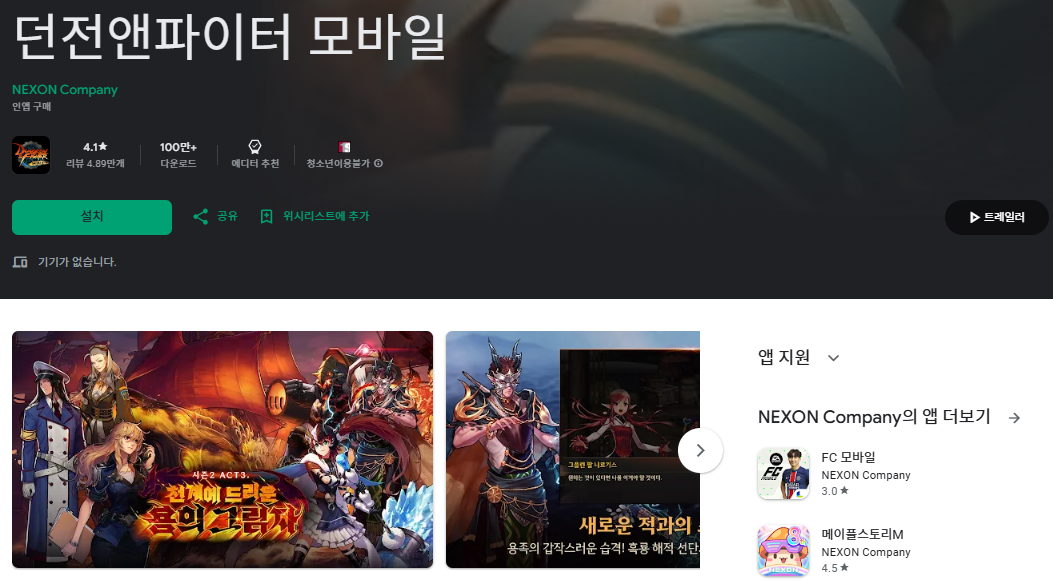

In [ ]:
## 웹 크롤링
# 목적: 게임 리뷰 데이터 수집
# 조건: ①시간, ②시간을 설정하여, 수집할 데이터 인덱스 고정

try:
    print('크롤링 시작(Start Crawling)')

    data_list = []                                                                    # 리뷰 데이터를 담을 리스트 정의
    one_review_count = 0                                                              # 리뷰 데이터의 고유번호 생성을 위한 변수 정의
    review_number = 7000                                                              # 스크롤 다운할 경우, 수집을 시작할 리뷰 인덱스 위치(중복된 데이터가 없도록하기 위한 기능)

    # Chrome브라우저 기본 기본옵션 설정
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--no-sandbox')                                       # Chrome의 샌드박스 기능 비활성화
    chrome_options.add_argument('--disable-dev-shm-usage')                            # Chrome이 /dev/shm(공유 메모리)를 사용하는 것을 비활성화
    chrome_options.add_argument('--disable-blink-features=AutomationControlled')      # Blink 엔진에서 자동화 제어 관련 기능을 비활성화

    # 크롬드라이브 위치 설정
    chrome_driver = 'Data/chrome_d/chromedriver.exe'
    driver = webdriver.Chrome(chrome_driver, options = chrome_options)

    # 크롬드라이브가 접근할 홈페이지(URL) 설정
    driver.get('https://play.google.com/store/apps/details?id=com.nexon.mdnf')
    click_element(driver)

    # 페이지 로딩 대기
    wait = WebDriverWait(driver, 5)

    # 페이지 무한 스크롤 다운
    modal = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.XPATH, "//div[@class='fysCi']")))
    scroll(modal, 22)

    while 1:
        # 수집정보: 리뷰 데이터 선택
        print(review_number, "개 고객 리뷰 데이터 크롤링 중")
        all_one_review = driver.find_elements_by_xpath('//*[@id="yDmH0d"]/div[4]/div[2]/div/div/div/div/div[2]/div/div[1]/div[' + str(review_number) + ']')
        one_review = str(all_one_review[0].text).split('\n')
        time.sleep(pause_time)

        one_review_count      += 1                 # ①수집정보: (A리뷰 데이터에 대한) 리뷰ID
        one_review_userID     = one_review[0]      # ②수집정보: (A리뷰 데이터에 대한) 고객ID
        one_review_write_date = one_review[2]      # ③수집정보: (A리뷰 데이터에 대한) 작성일자
        one_review_reviewer   = one_review[3]      # ④수집정보: (A리뷰 데이터에 대한) 리뷰어
        one_review_Usefulness = one_review[4]      # ⑤수집정보: (A리뷰 데이터에 대한) 유용성 정보
        time.sleep(pause_time)

        # 수집정보: HTML구조가 달라서, 수집정보의 평점에 따라 상이하게 설정
        one_review_star = all_one_review[0].find_elements_by_xpath('//*[@id="yDmH0d"]/div[4]/div[2]/div/div/div/div/div[2]/div/div[1]/div[' + str(review_number) + ']/header/div[2]/div')[0]
        one_review_star = one_review_star.get_attribute('aria-label')
        time.sleep(pause_time)

        # 수집정보: 리스트 정의(고객ID, 리뷰작성일자, 리뷰어, 유용성, 총평점)
        data_list.append([one_review_count, one_review_userID, one_review_write_date, one_review_reviewer, one_review_Usefulness, one_review_star])
        time.sleep(pause_time)

        ## 수집 리뷰 인덱스 증가
        #예시) 기존 100이면, '+1' 처리하여 다음 반복문에서 101번째 크롤링 진행)
        review_number += 1
        compare_data = review_number % 1000

        # 조건을 만족할 경우, 크롤링 다운 추가
        if 0 == compare_data and review_number>= 7499:
            modal = WebDriverWait(driver, 300).until(EC.element_to_be_clickable((By.XPATH, "//div[@class='fysCi']")))
            scroll(modal, 5)
            time.sleep(pause_time)
            # 1분 = 1700개 정도 크롤링 다운

finally:
    with open('Data/Dunpa_Mobile_Review05.csv', 'w', encoding='utf-8',  newline="") as f:
        writer = csv.writer(f)
        writer.writerow(['리뷰_ID', '고객_ID', '작성일자(전체)', '리뷰어', '유용성', '평점'])
        for u in data_list:
            writer.writerow(u)

print('크롤링   끝(End Crawling)')

In [ ]:
## 코드 리뷰

# 설명: 본 페이지는 구글 플레이에서 제공하는 '던전앤파이터 모바일' 앱에 작성된 게임 리뷰 데이터를 수집하는 크롤링 코드
# 특징: 크롤링을 위해 페이지 구조에 맞게 '클릭/스크롤 등' 기능을 추가하여 데이터 수집
# 참고사항:
# ①본 코드는 PC로컬 환경에서 크롤링되도록 작성
# ②웹 구조는 비정기적으로 변경되므로 속도와 읻게스 위치 등에 대한 설정값은 환경에 맞게 세팅 必
# ③페이지가 넘어갈 때 시간에 따라 스크롤 다운되는 속도가 상이하므로, 모든 데이터를 크롤링하기에는 한계 有

___